<center> <a href="https://githubtocolab.com/felixp8/lfads-nlb-tutorials/blob/main/understanding_lfads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> </center>

<a id='intro'></a>

# Understanding LFADS

Latent Factor Analysis via Dynamical Systems (Pandarinath et al. 2018), or LFADS, is a method using deep learning with artificial recurrent neural networks (RNNs) to model neural population activity. LFADS takes neural spiking data as an input and estimates the data's latent dynamics and de-noised neuron firing rates. No trial-specific information or behavioral information is required. When applied to a variety of datasets, the rates extracted by LFADS have been shown to estimate behavioral variables extremely well.

This tutorial aims to introduce some of the concepts necessary for understanding the inner workings of LFADS. Specifically, this tutorial will cover:
1. An overview of dynamical systems
2. Modeling neural populations using low-dimensional dynamics
3. LFADS architecture

The following tutorial, [Running LFADS](), will demonstrate how to use our lab's code to train an LFADS model on synthetic spiking data and tune its hyperparameters.

In [1]:
#@title Import Dependencies

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from numpy.random import rand
import numpy as np
from scipy.integrate import odeint

from IPython.display import display
%matplotlib inline

<a id='dynsys'></a>

## Part 1: Overview of Dynamical Systems

A dynamical system is a system which evolves in time, for which the rules defining this time evolution can be described using a set of differential equations:

$\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x},\mathbf{u},t)$

where $\mathbf{x}$ is the state of the system, $\mathbf{u}$ are external inputs to the system, $t$ is time and $\dot{\mathbf{x}}$ is short-hand notation for $\frac{d\mathbf{x}}{dt}$, that is, the derivative of $\mathbf{x}$ with respect to time. The above equation then defines the rate of change of the system state as a function of the current state, external inputs and time. 

In the case where the dynamical system does not depend on time (time-invariant), the system's equations are simplified to:

$\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x},\mathbf{u})$

and if there are no external inputs (autonomous), it can be further simplified to:

$\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x})$

In other words, with a time-invariant autonomous dynamical system, given a certain state $\mathbf{x}$, we can compute the direction in which this state will evolve across time.

### 1.1. Autonomous linear dynamical systems
To demonstrate some basic concepts of dynamical systems, we will first look at an **autonomous linear** dynamical system. A linear dynamical system is a dynamical system where the system equations are linear and can be represented as a matrix operation. Because the system is autonomous, with no external inputs, the equation can be written as:

$\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}) = \mathbf{A}\mathbf{x}$

We will work with a 2D linear system for which:

$\begin{bmatrix}\dot{x}_1 \\ \dot{x}_2\end{bmatrix} = \begin{bmatrix} 0 & 1 \\ -1 & 0\end{bmatrix}\begin{bmatrix}x_1 \\ x_2\end{bmatrix}$

We will see shortly that, without external inputs, this system corresponds to an oscillator, since the trajectories which fit these equations oscillate around a point. 

In [2]:
### Define equations for a 2D linear oscillator

def f_osc(x, t):

    # separate state variables
    x1 = x[0]
    x2 = x[1]

    # define differential equations (ignoring inputs for now)
    dx1dt = x2
    dx2dt = -x1
  
    return np.array([dx1dt, dx2dt])

A way to visualize the dynamics of a system is using vector fields, which evaluate $\dot{\mathbf{x}}$ at different points with zero input, and thus show the direction and rate of change of the system through state-space.

In [3]:
### Define 2d quiver plot function

def plot_2d_quiver(f, ax, xlims=(-1.5,1.5), ylims=(-1.5,1.5)):
  
    # extract plot limits
    xmin = xlims[0]
    xmax = xlims[1]
    ymin = ylims[0]
    ymax = ylims[1]

    # setup plot
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

    # compute and plot vectors for different values in state-space
    y1 = np.linspace(xmin, xmax, 20)
    y2 = np.linspace(ymin, ymax, 20)
    Y1, Y2 = np.meshgrid(y1, y2)
    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
    NI, NJ = Y1.shape
    for i in range(NI):
        for j in range(NJ):
            x = Y1[i, j]
            y = Y2[i, j]
            yprime = f([x, y], 0)
            u[i,j] = yprime[0]
            v[i,j] = yprime[1]
    ax.quiver(Y1, Y2, u, v, color='gray')

We plot the vector field for the oscillator, as well as the trajectories for different initial conditions.

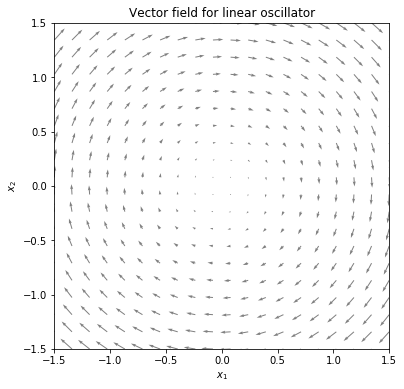

In [4]:
### Plot vector field for 2D linear oscillator

# initialize plot
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
plt.title("Vector field for linear oscillator")
# plot vector field
plot_2d_quiver(f_osc, ax)

Note how for any point in space, the direction of the vector field rotates around the origin, showing that this corresponds to an oscillator. 

We will now plot the trajectories for the state starting at different initial conditions.

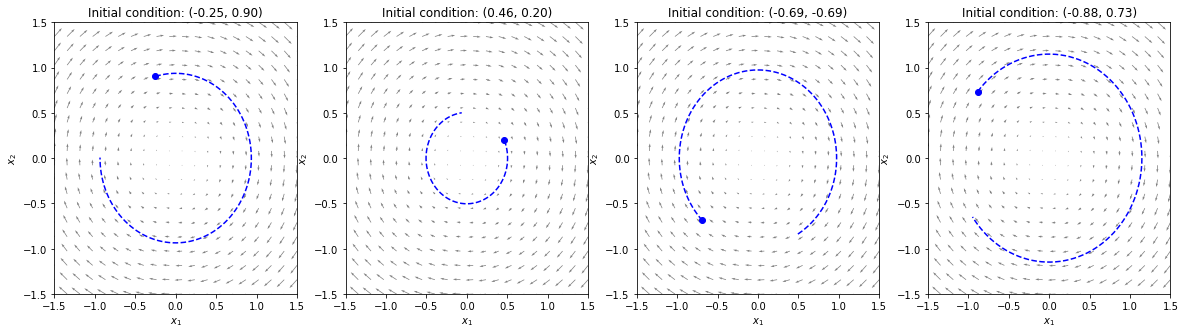

In [5]:
### Plot trajectories for 2D linear oscillator starting at different initial conditions

# set seed for generating random values
np.random.seed(42)

# total time duration of simulation
T = 5      
# timestep for simulation
dt = 0.01 
# time vector for simulation 
t = np.arange(0, T, dt) 

# initialize plot
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    # plot vector field
    plot_2d_quiver(f_osc, ax[i])
    # generate random initial condition between -1 and 1
    x0 = 2*(np.random.rand(1,2) - 0.5)
    # generate trajectory by integrating system differential equations, given an initial condition
    x = odeint(f_osc, x0[0,:], t)
    # plot initial condition (shown by dot)
    ax[i].plot(x[0,0],x[0,1],'bo')
    ax[i].set_title('Initial condition: ({:4.2f}, {:4.2f})'.format(x[0,0],x[0,1]))
    # plot trajectory
    ax[i].plot(x[:,0],x[:,1],'b--')

In the above plots, different initial conditions (dots) and the resulting trajectory (dashed line) are shown. We see that there are consistent rules which govern how the trajectories evolve through time. Also, we see that the trajectories themselves only depend on the initial conditions and evolve autonomously from there. So, we can represent the whole trajectory only with knowledge of the initial state and the system rules.

In modeling, we are often given the trajectories and tasked with determining the rules of the dynamical system. With linear dynamical systems, this is fairly straightforward. We have $\mathbf{x}$, meaning we can estimate $\mathbf{\dot{x}}$ and thus solve for $\mathbf{A}$ with linear regression.

### 1.2. General linear dynamical systems
In a more general case, our dynamical system can also have external inputs, resulting in the following formulation:

$\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x},\mathbf{u}) = \mathbf{A}\mathbf{x} + \mathbf{B}\mathbf{u}$

Incorporating inputs into the oscillator from before, we can define the system as:

$\begin{bmatrix}\dot{x}_1 \\ \dot{x}_2\end{bmatrix} = \begin{bmatrix} 0 & 1 \\ -1 & 0\end{bmatrix}\begin{bmatrix}x_1 \\ x_2\end{bmatrix} + \begin{bmatrix} 1 \\ -1 \end{bmatrix} u$

where 1-dimensional input $u$ is added to $\dot{x}_1$ and subtracted from $\dot{x}_2$.

In [6]:
### Define equations for a 2D linear oscillator with external input

def f_osc_input(x, t, u=(lambda t: 0)):

    # separate state variables
    x1 = x[0]
    x2 = x[1]

    # define differential equations
    dx1dt = x2 + u(t)
    dx2dt = -x1 + -u(t)
  
    return np.array([dx1dt, dx2dt])

We will plot the trajectories for various initial conditions again, but this time with a pulse of random magnitude as external input.

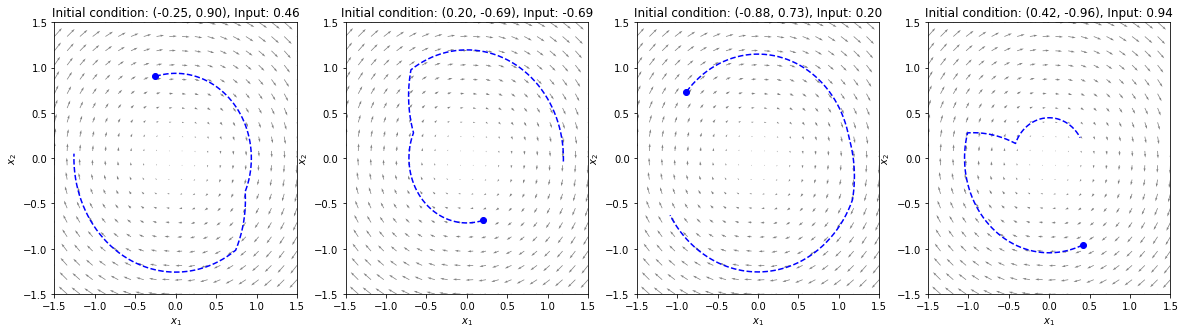

In [7]:
### Plot trajectories for 2D linear oscillator starting at different initial conditions

# set seed for generating random values
np.random.seed(42)

# total time duration of simulation
T = 5      
# timestep for simulation
dt = 0.01 
# time vector for simulation 
t = np.arange(0, T, dt) 

# initialize plot
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    # plot vector field
    plot_2d_quiver(f_osc, ax[i])
    # generate random initial condition between -1 and 1
    x0 = 2*(np.random.rand(1,2) - 0.5)
    # define pulse external input between -2 and 2 for middle 50 timesteps
    u0 = 2*(np.random.random() - 0.5)
    u = lambda t: u0 * int((t >= (T / 2 - dt * 25)) and (t < (T / 2 + dt * 25)))
    # generate trajectory by integrating system differential equations, given an initial condition
    x = odeint(f_osc_input, x0[0,:], t, (u,))
    # plot initial condition (shown by dot)
    ax[i].plot(x[0,0],x[0,1],'bo')
    ax[i].set_title('Initial condition: ({:4.2f}, {:4.2f}), Input: {:4.2f}'.format(x[0,0],x[0,1],u0))
    # plot trajectory
    ax[i].plot(x[:,0],x[:,1],'b--')

Unlike the autonomous dynamical systems, the trajectories here do not simply follow the intrinsic dynamic rules. So, the initial state and the system rules alone are insufficient to describe the observed trajectories. Instead, the external time-varying inputs allow for a richer variety of behaviors, here enabling the system to essentially jump from one oscillatory state of fixed radius to another.

As with autonomous linear dynamical systems, we can solve for the system rules with linear regression. However, we must know the external inputs $\mathbf{u}$ in addition to $\mathbf{x}$ in order to do this.

### 1.3. Nonlinear Dynamical Systems

A more general family of dynamical systems are those known as **nonlinear** dynamical systems, for which $\mathbf{f}(\mathbf{x},\mathbf{u})$ cannot be represented as a matrix transform. This type of systems allows much richer trajectories than linear ones, and real-world systems are usually better represented by nonlinear dynamics. For this tutorial, we will work with a Lorenz attractor, which is an autonomous 3-dimensional nonlinear system described by the following equations:

$\begin{bmatrix}\dot{x}_1 \\ \dot{x}_2 \\ \dot{x}_3\end{bmatrix} = \begin{bmatrix}\sigma(x_2-x_1) \\ x_1(\rho-x_3) - x_2 \\ x_1x_2 - \beta x_3 \end{bmatrix} $

With parameters $\sigma=10$, $\beta=8/3$, and $\rho=28$.

This system describes quite complex trajectories, as shown in the following animation:

<!--- ![](https://upload.wikimedia.org/wikipedia/commons/1/13/A_Trajectory_Through_Phase_Space_in_a_Lorenz_Attractor.gif) --->

In [8]:
## Define equations for a Lorenz system

def f_lorenz(x,t):

    # separate state variables
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]

    # define system parameters
    sigma = 10
    beta = 8/3
    rho = 28

    # define differential equations
    dx1dt = sigma*(x2-x1)
    dx2dt = x1*(rho-x3) - x2
    dx3dt = x1*x2 - beta*x3

    return np.array([dx1dt, dx2dt, dx3dt])

Visualizing vector fields is harder in 3D, so we will skip that step for this system, and plot the state trajectories starting at different initial conditions:

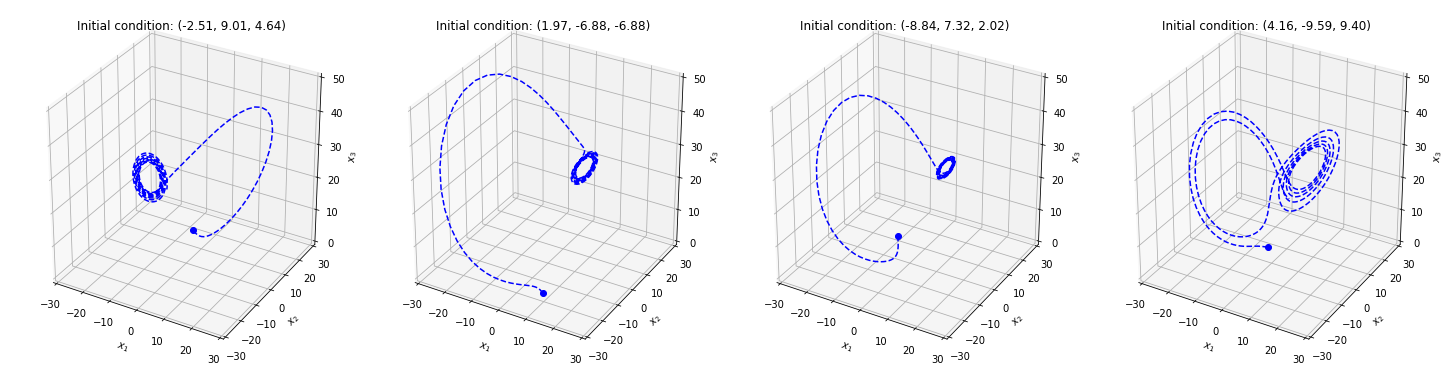

In [9]:
### Plot trajectories for Lorenz system starting at different initial conditions

# set seed for generating random values
np.random.seed(42)

# total time duration of simulation
T = 5      
# timestep for simulation
dt = 0.01 
# time vector for simulation 
t = np.arange(0, T, dt) 

# initialize plot
fig = plt.figure(figsize=(20, 5), constrained_layout=True)

for i in range(4):
    # initialize 3D plot axes
    ax = fig.add_subplot(1, 4, i+1, projection='3d')
    ax.set_xlim3d(left=-30, right=30)
    ax.set_ylim3d(bottom=-30, top=30)
    ax.set_zlim3d(bottom=0, top=50)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$x_3$')
    # generate random initial condition between -10 and 10
    x0 = 20*(np.random.rand(1,3) - 0.5)
    # generate trajectory by integrating system differential equations, given an initial condition
    x = odeint(f_lorenz, x0[0,:], t)
    # plot initial condition (shown by dot)
    ax.plot3D(x[0:1,0],x[0:1,1],x[0:1,2],'bo')
    ax.set_title('Initial condition: ({:4.2f}, {:4.2f}, {:4.2f})'.format(x[0,0],x[0,1],x[0,2]))
    # plot trajectory
    ax.plot3D(x[:,0],x[:,1],x[:,2],'b--')

Note how differences in the initial condition lead to very different trajectories through time. But again, these trajectories can be fully determined just from the initial state.

If we proceed to plot several trajectories at the same time:

Text(0.5, 0.92, 'Trajectories for Lorenz system for multiple initial conditions')

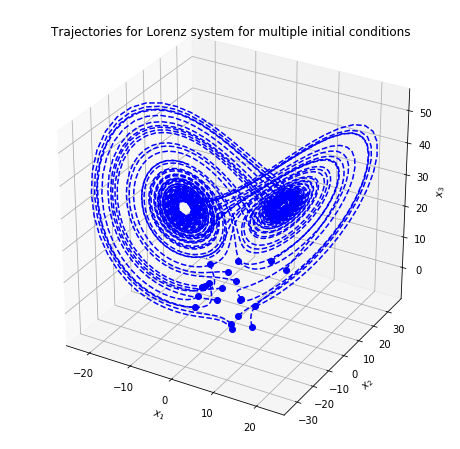

In [10]:
### Plot trajectories for Lorenz system for multiple initial conditions

# set seed for generating random values
np.random.seed(42)

# total time duration of simulation
T = 5      
# timestep for simulation
dt = 0.01 
# time vector for simulation 
t = np.arange(0, T, dt) 

# initialize plot
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

for i in range(20):
    x0 = 10*2*(np.random.rand(1,3) - 0.5)
    x = odeint(f_lorenz, x0[0,:], t)

    ax.plot3D(x[:,0],x[:,1],x[:,2],'b--')
    ax.plot3D(x[0:1,0],x[0:1,1],x[0:1,2],'bo')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
ax.set_title('Trajectories for Lorenz system for multiple initial conditions')

When several trajectories are plotted, the structure of the system becomes apparent. We can see that there are consistent rules which govern how the trajectories evolve through time, despite how complex these seem.

Unlike with linear dynamical systems, modeling nonlinear dynamical systems is not possible with simple linear regression. Unfortunately, many biological dynamical systems of interest are nonlinear, so more flexible methods must be used to model them.

<a id="ctd"></a>

## Part 2: Modeling neural populations using low-dimensional dynamics

<!-- Traditional methods for analyzing single-neuron activity often involved averaging responses across trials to overcome high trial-to-trial variability in spiking, resulting in firing rate estimates called peristimulus time histograms (PSTHs). However, trial averaging discards the potentially valuable information in single-trial variance, limiting the insights that can be drawn from the data. New methods would be needed to extract firing rate estimates from sparse and noisy spiking data on a single-trial basis.

In parallel, our ability to simultaneously record from multiple neurons has dramatically improved in the past decades, jumping from just a handful of neurons at a time in the 1970s to over 3000 in the 2010s. Notably, the high-dimensional activity of neural populations in a number of brain regions has been found to exhibit shared structure that is well described by low-dimensional neural population states. Leveraging this shared variance across neurons, methods ranging in complexity from PCA to deep neural networks have found success in denoising single-trial neural activity. --->

Our ability to simultaneously record from multiple neurons has dramatically improved in the past decades, jumping from just a handful of neurons at a time in the 1970s to over 3000 in the 2010s. The activity of these neural populations evolves over time, and one way to attempt to make sense of these patterns of activity is to think of them as dynamical systems.

Under this perspective, the connections between the neurons in a population define a dynamical system, where the activity of each neuron affects the change in firing rate of all the other neurons it is connected to. External inputs to the system would be synaptic inputs from neurons outside the population, like sensory feedback in the motor system.

However, with hundreds or thousands of neurons, the resulting high-dimensional systems would be prohibitively difficult to understand and visualize, and this is still only a small fraction of the number of neurons involved in neural computation. Fortunately, the high-dimensional activity of neural populations in a number of brain regions has been found to exhibit shared structure that is well described by low-dimensional neural population states. To put it more concretely, if you were to take the firing rates of a set of $N$ neurons and plot their trajectories through $N$-d space, you will often find that they lie mostly upon a lower-dimensional manifold, as seen below with a 3-d system of neurons and a 2-d manifold.

<center><img src="https://github.com/felixp8/lfads-nlb-tutorials/blob/main/images/lin_manifold.png?raw=true" width="400"></img></center>

A common assumption then is that each neuron's firing rate is a projection from a low-dimensional population state. We can simulate this, taking the Lorenz system as an example.

We create a population of 60 neurons, where each neuron's firing rate at a particular point in time is a linear combination of the three state variables of the Lorenz system. We also exponentiate the resulting value to prevent negative firing rates.


> **Note:** In generating synthetic datasets for training models (like the dataset we use in [Running LFADS]()), we use simulate multiple initial conditions to get different trials.

Text(0.5, 1.0, 'Neuron 3')

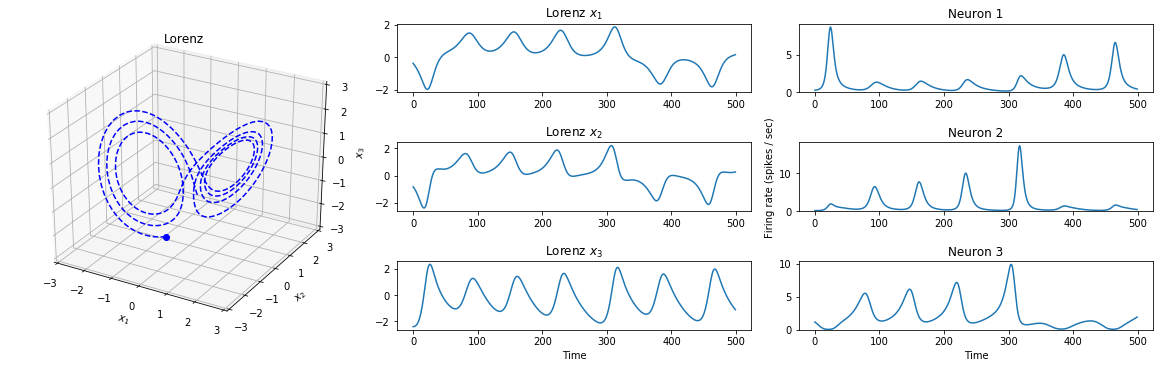

In [11]:
### Simulate 60 neurons from a Lorenz trajectory

# set seed for generating random values
np.random.seed(42)

# total time duration of simulation
T = 5    
# timestep for simulation
dt = 0.01 
# time vector for simulation 
t = np.arange(0, T, dt) 

# initialize random mapping from 3-d Lorenz state to 60 neurons
readout = np.random.uniform(-1.0, 1.0, (3, 60))

# simulate Lorenz trajectory
x0 = 10*2*(np.random.rand(1,3) - 0.5)
x = odeint(f_lorenz, x0[0,:], t)

# approximately standardize the trajectory
# subtracting mean and dividing by standard deviation
x -= np.array([[0, 0, 25.8]])
x /= np.array([[8.6, 9.4, 7.2]])
n = x @ readout
n = np.exp(n)

fig = plt.figure(figsize=(16, 5), constrained_layout=True)
gs = fig.add_gridspec(3,3)

ax = fig.add_subplot(gs[:, 0], projection='3d')
ax.set_xlim3d(left=-3, right=3)
ax.set_ylim3d(bottom=-3, top=3)
ax.set_zlim3d(bottom=-3, top=3)
ax.plot3D(x[:,0],x[:,1],x[:,2],'b--')
ax.plot3D(x[0:1,0],x[0:1,1],x[0:1,2],'bo')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
ax.set_title('Lorenz')

ax = fig.add_subplot(gs[0, 1])
ax.plot(x[:, 0])
ax.set_title('Lorenz $x_1$')

ax = fig.add_subplot(gs[1, 1])
ax.plot(x[:, 1])
ax.set_title('Lorenz $x_2$')

ax = fig.add_subplot(gs[2, 1])
ax.plot(x[:, 2])
ax.set_xlabel('Time')
ax.set_title('Lorenz $x_3$')

ax = fig.add_subplot(gs[0, 2])
ax.plot(n[:, 0])
ax.set_ylim(0)
ax.set_title('Neuron 1')

ax = fig.add_subplot(gs[1, 2])
ax.plot(n[:, 1])
ax.set_ylim(0)
ax.set_ylabel('Firing rate (spikes / sec)')
ax.set_title('Neuron 2')

ax = fig.add_subplot(gs[2, 2])
ax.plot(n[:, 2])
ax.set_ylim(0)
ax.set_xlabel('Time')
ax.set_title('Neuron 3')

We can then generate spike times by sampling from a Poisson distribution with a mean equal to the firing rate times the bin size at each timestep.

Text(0.5, 1.0, 'Spiking')

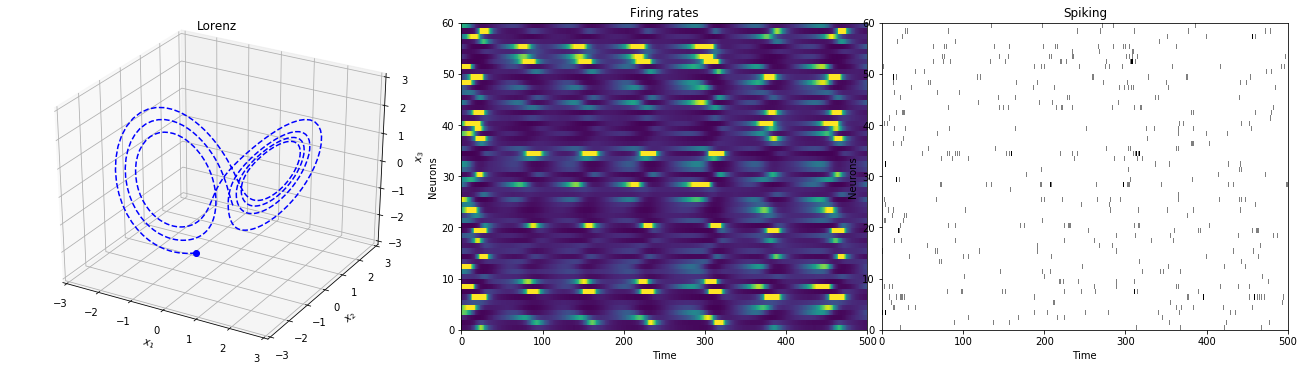

In [12]:
### Sample and plot spikes

spikes = np.random.poisson(n * dt)
spike_times = [np.where(spikes[:, i])[0] for i in range(30)]

fig = plt.figure(figsize=(18, 5))

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.set_xlim3d(left=-3, right=3)
ax.set_ylim3d(bottom=-3, top=3)
ax.set_zlim3d(bottom=-3, top=3)
ax.plot3D(x[:,0],x[:,1],x[:,2],'b--')
ax.plot3D(x[0:1,0],x[0:1,1],x[0:1,2],'bo')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
ax.set_title('Lorenz')

ax = fig.add_subplot(1, 3, 2)
im = ax.pcolor(n.T, vmin=0, vmax=10)
ax.set_xlabel('Time')
ax.set_ylabel('Neurons')
ax.set_title('Firing rates')

ax = fig.add_subplot(1, 3, 3)
im = ax.pcolor(spikes.T, cmap=cm.binary, vmin=0, vmax=2)
ax.set_xlabel('Time')
ax.set_ylabel('Neurons')
ax.set_title('Spiking')

plt.tight_layout()

Though the system dynamics are still visible in the firing rates, the neuron spiking is sparse and difficult to discern structure in, much like neural activity we observe experimentally. 

Thus, under this dynamical systems assumption, a key question is this: *If we know that the spiking activity is generated from an underlying dynamical system, can we infer the true firing rates from the spiking activity by modeling those underlying dynamics?*

Several standard neural population modeling methods, including LFADS, take this approach and have seen significant success in extracting structure from noisy population activity.

## Part 3: The LFADS architecture

As seen earlier, to model a dynamical system, we need to know 3 things:
1. The underlying dynamical rules, which relate the trajectory of the system to its current state and external inputs
2. The initial condition of the system
3. The time-varying external inputs to the system

The LFADS architecture is designed to learn and compute these 3 things from the data. In addition, it needs to learn the mapping between each neuron and the underlying dynamics.

### 3.1. Modeling dynamics with the generator

To model the dynamics, we need to learn the relationship between the current system state and external input and the next state. In a linear dynamical system, this relationship can be expressed in matrices and the parameters can be solved for using linear regression. However, a non-linear system cannot be described or solved for as simply, so we need a more powerful method. 

One option is a recurrent neural network (RNN). RNNs are a type of artificial neural network designed to process temporal data. At each timestep, it receives an external input and its previous state to compute an updated state, much like a dynamical system. The internal RNN update functions are non-linear, allowing it to capture extremely complex dynamics. RNNs have been proven to be "universal approximators" for dynamical systems, meaning they can mathematically fit any dynamical system in theory.

LFADS uses an RNN we call the **generator** to model the dynamics. The generator receives an initial condition and external inputs from other parts of LFADS, and its internal state is mapped through linear transformations and an exponentiation to output firing rates.

Below, we have a diagram for the architecture of the generator.

<center><img src="https://github.com/felixp8/lfads-nlb-tutorials/blob/main/images/generator_nonvar.png?raw=true" width="800"></img></center>

### 3.2. Calculating initial conditions with the encoder

The generator needs an initial condition to begin modeling the dynamics. The initial condition must also be inferred from the data. To do this, LFADS again uses an RNN we call the **encoder**, this time not to model the dynamics but to process the entirety of the sequence and extract information relevant to identifying an initial condition. The RNN is bidirectional, meaning that it is essentially two RNNs: one that processes the sequence forward in time and one that processes it moving backwards in time.

Below, we have a diagram of the architecture of the encoder.

<center><img src="https://github.com/felixp8/lfads-nlb-tutorials/blob/main/images/encoder_nonvar.png?raw=true" width="800"></img></center>

### 3.3. Estimating external inputs with the controller

Lastly, the generator needs external inputs to continue modeling the dynamics after the initial condition. LFADS infers external inputs using one more RNN we call the **controller**. The controller itself technically has an encoder, which is a bidirectional RNN just like the main encoder. The controller's encoder outputs time-varying inputs to the controller. Then, at each timestep, the controller receives that input as well as the factor value output by the generator in the past timestep. 

<center><img src="https://github.com/felixp8/lfads-nlb-tutorials/blob/main/images/controller_nonvar.png?raw=true" width="800"></img></center>

### 3.4. Putting it all together

The full model is shown in the block diagram below. Note that the two separate encoder, one for the initial condition and one for the controller input, but they are shown as the same bidirectional encoder network in the diagram for space.

<center><img src="https://github.com/felixp8/lfads-nlb-tutorials/blob/main/images/lfads_nonvar.png?raw=true" width="800"></img></center>

So, LFADS takes spiking as input and produces firing rate predictions as output. The rate predictions are evaluated by calculating the Poisson likelihood of the spiking given the predicted firing rates. The model is trained to maximize that likelihood, or, more accurately to minimize the negative log-likelihood.

<center><img src="https://github.com/felixp8/lfads-nlb-tutorials/blob/main/images/lfads_nonvar_2.jpg?raw=true" width="800"></img></center>

## Summary and Conclusions

In this tutorial, we saw how a dynamical systems perspective can be applied to neural population activity by assuming that the observed activity is a noisy sampling of a high-dimensional readout from a low-dimensional underlying dynamical system. We developed an intuition for how LFADS is designed for these assumptions and uses RNNs to compute everything necessary to model the dynamics.

Now that you have a better understanding of the model, you can learn how to use it in our notebook, [Running LFADS]().

## Appendix

### A.1. LFADS as a variational autoencoder

A key aspect of LFADS that is overlooked in this tutorial for simplicity is that it is a variational autoencoder. Unlike what is described above, the outputs of the encoder and the generator are not single vectors but rather **distributions** - a mean and variance for each element of the vectors. Then, on each forward pass, each value is sampled from the normal distribution defined by that mean and variance and that sample is input into the generator.

The motivation for a variational approach is that introducing this randomness induces the model to learn a more continuous mapping in the sampling space. Essentially, the model can no longer learn to associate an exact vector with a particular input, as it can not expect that exact vector every time for a given input.

Of course, the model could simply learn to output vastly different means and zero variances, achieving exactly what it could without the variational approach. This is prevented using a special regularization term in the loss, Kullback-Leibler divergence. Like L2 and L1 regularization norms penalize large parameter values, the KL divergence penalizes output distributions that are significantly different from a prior distribution, typically normal distribution with zero mean and a fixed variance. As with other regularization schemes, the weighting of this term needs to be carefully balanced to prevent both under- and overfitting.

<center><img src="https://github.com/felixp8/lfads-nlb-tutorials/blob/main/images/lfads_full.png?raw=true" width="800"></img></center>